In [ ]:
!pip install beautifulsoup4

In [ ]:
!pip install selenium

In [ ]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [137]:
import requests
from bs4 import BeautifulSoup

import pickle
import time
from datetime import date, datetime
from dateutil.parser import parse as parse_date

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.interpolate import make_interp_spline, BSpline

# Data Collection

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

In [ ]:
URL_f = lambda page: f"https://www.mtggoldfish.com/series/budget-magic?page={page}"

In [ ]:
def parse_landing_page_for_articles(URL):
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  results = soup.find_all("div", class_="article-tile-title")

  article_names_and_links = {}

  for article_title in results:
    link = article_title.find("a", class_="stealth-link")
    article_names_and_links[link.text] = "https://www.mtggoldfish.com" + link["href"]
  
  return article_names_and_links

In [ ]:
article_names_and_links = {}

for page in range(1, 23):
  article_names_and_links.update(parse_landing_page_for_articles(URL_f(page)))

In [ ]:
print(article_names_and_links)

{"Budget Magic: $72 (12 tix) Maze's End Gates (Pioneer)": 'https://www.mtggoldfish.com/articles/budget-magic-72-12-tix-maze-s-end-gates-pioneer', 'Budget Magic: 15-Rare Burn (Historic)': 'https://www.mtggoldfish.com/articles/budget-magic-15-rare-burn-historic', 'The Most Expensive $75 Deck in Modern | Calibrated Blast | Budget Magic': 'https://www.mtggoldfish.com/articles/the-most-expensive-75-deck-in-modern-calibrated-blast-budget-magic', 'Budget Magic: $100 Rokiric Multicolor Boros (Modern)': 'https://www.mtggoldfish.com/articles/budget-magic-100-rokiric-multicolor-boros-modern', 'Top 10 Budget Magic Modern Decks of 2021': 'https://www.mtggoldfish.com/articles/top-10-budget-magic-modern-decks-of-2021', "Budget Magic: Torens' Monument (Modern)": 'https://www.mtggoldfish.com/articles/budget-magic-torens-monument-modern', 'Buttget Magic: $97 Doran Cannot Lie (Modern)': 'https://www.mtggoldfish.com/articles/buttget-magic-97-doran-cannot-lie-modern', 'Budget Magic: $90 Bloody Burn (Modern

In [ ]:
article_details = []

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

browser = webdriver.Chrome('chromedriver', options=chrome_options)

for i, (article_name, url) in enumerate(article_names_and_links.items()):
  print(f"Beginning query ({i}/{len(article_names_and_links)}) for ", url)

  try:
    browser.get(url)
    timeout_in_seconds = 10
    WebDriverWait(browser, timeout_in_seconds).until(ec.presence_of_element_located((By.CLASS_NAME, 'deck-main-contents')))
    html = browser.page_source
    soup = BeautifulSoup(html, features="html.parser")

    date = parse_date(str.strip(soup.find("div", class_="article-author").text.split("//")[-1]))
    deck_prices = soup.find("div", class_="header-prices-currency")

    paper_price = float(deck_prices.find("div", class_="deck-price-v2 paper").text.replace("\xa0", "").replace("\n", "0").replace("$", ""))
    online_price = float(deck_prices.find("div", class_="deck-price-v2 online").text.replace("\xa0", "").replace("\n", "0").replace("tix", ""))
    
    parsed_data = {
        "title": article_name,
        "url": url,
        "date": date,
        "paper_price": paper_price,
        "online_price": online_price
    }

    article_details += [parsed_data]

    print("Finished query: ", parsed_data)

  except TimeoutException:
      print("Ran out of time!")

browser.quit()

Beginning query (0/350) for  https://www.mtggoldfish.com/articles/budget-magic-72-12-tix-maze-s-end-gates-pioneer
Finished query:  {'title': "Budget Magic: $72 (12 tix) Maze's End Gates (Pioneer)", 'url': 'https://www.mtggoldfish.com/articles/budget-magic-72-12-tix-maze-s-end-gates-pioneer', 'date': datetime.datetime(2022, 2, 7, 0, 0), 'paper_price': 72.61, 'online_price': 24.35}
Beginning query (1/350) for  https://www.mtggoldfish.com/articles/budget-magic-15-rare-burn-historic
Finished query:  {'title': 'Budget Magic: 15-Rare Burn (Historic)', 'url': 'https://www.mtggoldfish.com/articles/budget-magic-15-rare-burn-historic', 'date': datetime.datetime(2022, 1, 24, 0, 0), 'paper_price': 41.89, 'online_price': 38.0}
Beginning query (2/350) for  https://www.mtggoldfish.com/articles/the-most-expensive-75-deck-in-modern-calibrated-blast-budget-magic
Finished query:  {'title': 'The Most Expensive $75 Deck in Modern | Calibrated Blast | Budget Magic', 'url': 'https://www.mtggoldfish.com/artic

In [ ]:
with open('budget_magic_raw.pkl', 'wb') as f:
  pickle.dump(article_details, f)

In [ ]:
with open('budget_magic_raw.pkl', 'rb') as f:
  budget_magic_data = pickle.load(f)

In [ ]:
budget_magic_data = list(filter(lambda data: isinstance(data['paper_price'], float), budget_magic_data))

In [ ]:
print(len(budget_magic_data))

350


In [ ]:
df = DataFrame(budget_magic_data)
df.set_index('date')

,title,url,paper_price,online_price
date,,,,
2022-02-07,Budget Magic: $72 (12 tix) Maze's End Gates (P...,https://www.mtggoldfish.com/articles/budget-ma...,72.61,24.35
2022-01-24,Budget Magic: 15-Rare Burn (Historic),https://www.mtggoldfish.com/articles/budget-ma...,41.89,38.00
2022-01-10,The Most Expensive $75 Deck in Modern | Calibr...,https://www.mtggoldfish.com/articles/the-most-...,75.16,12.00
2022-01-03,Budget Magic: $100 Rokiric Multicolor Boros (M...,https://www.mtggoldfish.com/articles/budget-ma...,98.00,36.90
2021-12-27,Top 10 Budget Magic Modern Decks of 2021,https://www.mtggoldfish.com/articles/top-10-bu...,161.78,231.59
...,...,...,...,...
2015-05-07,Budget Magic: $97 (38 tix) Standard Abzan Rally,https://www.mtggoldfish.com/articles/budget-ma...,72.72,2.45
2015-04-29,Budget Magic: $175 (67 tix) Standard Wg Prowess,https://www.mtggoldfish.com/articles/budget-ma...,191.27,39.77
2015-04-15,Budget Magic: $97 (22 tix) Modern Infinite Pil...,https://www.mtggoldfish.com/articles/budget-ma...,115.77,3.35


In [ ]:
df.to_excel('budget_magic_data.xlsx', sheet_name='Price Data - Feb 15, 2022')

In [ ]:
cutoff_date = '2021-09-24'
df = df[df["date"] < cutoff_date]

In [ ]:
df.set_index("date")

,title,url,paper_price,online_price
date,,,,
2021-09-20,Budget Magic: 14 Rare Temur Energy (Historic),https://www.mtggoldfish.com/articles/budget-ma...,77.83,39.34
2021-09-14,Budget Magic: $35 Mono-Black Treasure Discard ...,https://www.mtggoldfish.com/articles/budget-ma...,40.88,2.99
2021-08-30,Budget Magic: 12 Whack Goblins | $77 | Modern,https://www.mtggoldfish.com/articles/budget-ma...,86.04,21.52
2021-08-23,Budget Magic: $12 Simic Kicker (Standard 2022),https://www.mtggoldfish.com/articles/budget-ma...,12.11,0.53
2021-08-16,Budget Magic: Enchantress (MH2 Modern),https://www.mtggoldfish.com/articles/budget-ma...,97.19,17.81
...,...,...,...,...
2015-05-07,Budget Magic: $97 (38 tix) Standard Abzan Rally,https://www.mtggoldfish.com/articles/budget-ma...,72.72,2.45
2015-04-29,Budget Magic: $175 (67 tix) Standard Wg Prowess,https://www.mtggoldfish.com/articles/budget-ma...,191.27,39.77
2015-04-15,Budget Magic: $97 (22 tix) Modern Infinite Pil...,https://www.mtggoldfish.com/articles/budget-ma...,115.77,3.35


In [ ]:
def title_to_format(title):
  
  return {
      "upgrades": title.contains("")
  }

In [ ]:
test_tile = "Budget Magic: $40 (17 tix) Standard Mono B Humans"

In [ ]:
for title in df['title']:
  print(title)

# Visualization

In [139]:
categorical_colormap = cm.get_cmap('Paired')
rolling_mean_timeframe = '365D'

plt.rcParams["figure.figsize"] = (11,8.5)

pd.set_option('display.width', 1000)

In [140]:
df = pd.read_excel('/content/Budget Magic Data FINAL.xlsx')

In [141]:
df.columns

Index(['title', 'url', 'date', 'current_paper', 'current_online', 'og_paper_price', 'og_online_price', 'format', 'formatted_name', 'paper_delta', 'online_delta', 'paper_percent_change', 'online_percent_change'], dtype='object')

In [142]:
format_counts = df['format'].value_counts()

In [143]:
rolling_mean = df.set_index('date').rolling(rolling_mean_timeframe, center=True).mean()

In [144]:
modern_rows = df[df['format'] == 'Modern'].set_index('date')
standard_rows = df[df['format'] == 'Standard'].set_index('date')

modern_rolling_mean = modern_rows.rolling(rolling_mean_timeframe, center=True).mean()
standard_rolling_mean = standard_rows.rolling(rolling_mean_timeframe, center=True).mean()


In [166]:
overall_means = df.select_dtypes(include=['float64']).describe(percentiles=None)
modern_means = modern_rows.select_dtypes(include=['float64']).describe(percentiles=None)
standard_means = standard_rows.select_dtypes(include=['float64']).describe(percentiles=None)

pd.concat([overall_means, modern_means, standard_means], keys=['Overall', 'Modern', 'Standard'], axis=0).reset_index(level=1)

,level_1,current_paper,current_online,og_paper_price,og_online_price,paper_delta,online_delta,paper_percent_change,online_percent_change
Overall,count,322.000000,322.000000,281.000000,239.000000,281.000000,239.000000,281.000000,239.000000
Overall,mean,91.900186,15.030093,81.270463,29.236402,10.194804,-18.679958,0.130838,-0.514205
Overall,std,46.580702,22.049199,22.765532,17.751304,40.533349,17.991997,0.536386,0.704161
Overall,min,12.110000,0.470000,12.000000,0.500000,-71.040000,-72.080000,-0.757500,-0.969000
Overall,25%,57.427500,3.227500,67.000000,17.000000,-14.830000,-30.240000,-0.185729,-0.876034
Overall,50%,86.085000,9.435000,89.000000,26.000000,3.100000,-17.450000,0.038163,-0.721923
Overall,75%,116.762500,17.960000,98.000000,38.000000,23.750000,-8.630000,0.316224,-0.481222
Overall,max,293.920000,231.590000,175.000000,134.000000,195.920000,48.270000,3.988857,4.375000
Modern,count,140.000000,140.000000,128.000000,108.000000,128.000000,108.000000,128.000000,108.000000
Modern,mean,108.371929,19.735143,88.968750,27.856481,18.986406,-13.690556,0.220800,-0.333783


In [145]:
def scatter_plot_by_format(column, title, ylabel):
  colors = list(df['format'].unique())
  for i in range(0 , len(colors)):
      data = df.dropna(subset=[column]).loc[df['format'] == colors[i]]
      plt.scatter('date', column, data=data, color=categorical_colormap(i), label=colors[i], s=24)

  scatter_legend = plt.legend(labels=[f"{label} ({format_counts[label]})" for label in list(df['format'].unique())],
                              bbox_to_anchor=(1.02,0.65), loc="center left", title="Format")

  plt.plot(rolling_mean[column], color=categorical_colormap(len(colors)), linestyle='dashed')
  plt.plot(standard_rolling_mean[column], color=categorical_colormap(colors.index('Standard')), linestyle='dashed')
  plt.plot(modern_rolling_mean[column], color=categorical_colormap(colors.index('Modern')), linestyle='dashed')

  plt.legend(labels=["All", "Standard", "Modern"], bbox_to_anchor=(1.02,0.35), loc="center left", title=f"Average (1Y)")
  plt.gca().add_artist(scatter_legend)

  plt.xlabel('Release Date')
  plt.ylabel(ylabel)

  plt.title(title, fontsize=18)

  plt.grid()

  plt.show()

def bar_plot_by_format(column, title, ylabel):
  colors = list(df['format'].unique())
  for i in range(0 , len(colors)):
      data = df.dropna(subset=[column]).loc[df['format'] == colors[i]]
      plt.bar('date', column, data=data, color=categorical_colormap(i), label=colors[i], width=1.5)

  bar_legend = plt.legend(labels=[f"{label} ({format_counts[label]})" for label in list(df['format'].unique())],
                              bbox_to_anchor=(1.02,0.65), loc="center left", title="Format")

  plt.plot(rolling_mean[column], color=categorical_colormap(len(colors)), linestyle='dashed')
  plt.plot(standard_rolling_mean[column], color=categorical_colormap(colors.index('Standard')), linestyle='dashed')
  plt.plot(modern_rolling_mean[column], color=categorical_colormap(colors.index('Modern')), linestyle='dashed')

  plt.legend(labels=["All", "Standard", "Modern"], bbox_to_anchor=(1.02,0.35), loc="center left", title=f"Average (1Y)")
  plt.gca().add_artist(bar_legend)

  plt.xlabel('Release Date')
  plt.ylabel(f'{ylabel} (Feb 15, 2022)')

  plt.title(title, fontsize=18)

  plt.grid(axis='y')

  plt.show()

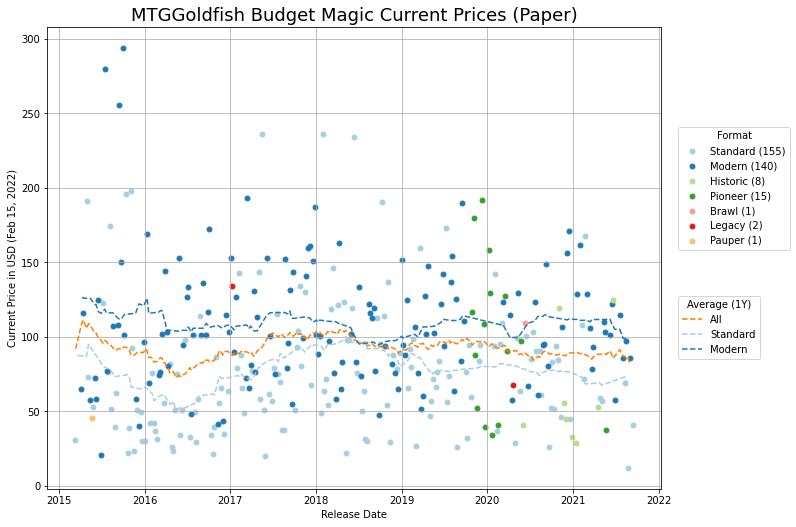

In [ ]:
scatter_plot_by_format('current_paper', 'MTGGoldfish Budget Magic Current Prices (Paper)', 'Current Price in USD (Feb 15, 2022)')

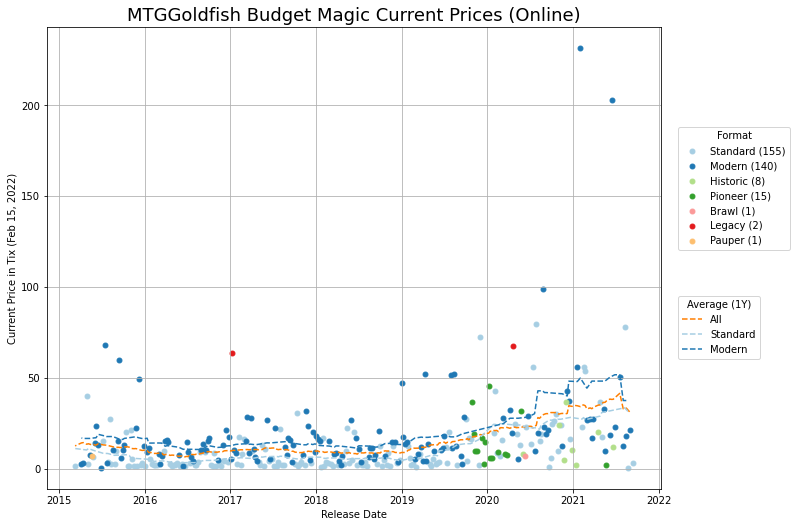

In [ ]:
scatter_plot_by_format('current_online', 'MTGGoldfish Budget Magic Current Prices (Online)', 'Current Price in Tix (Feb 15, 2022)')

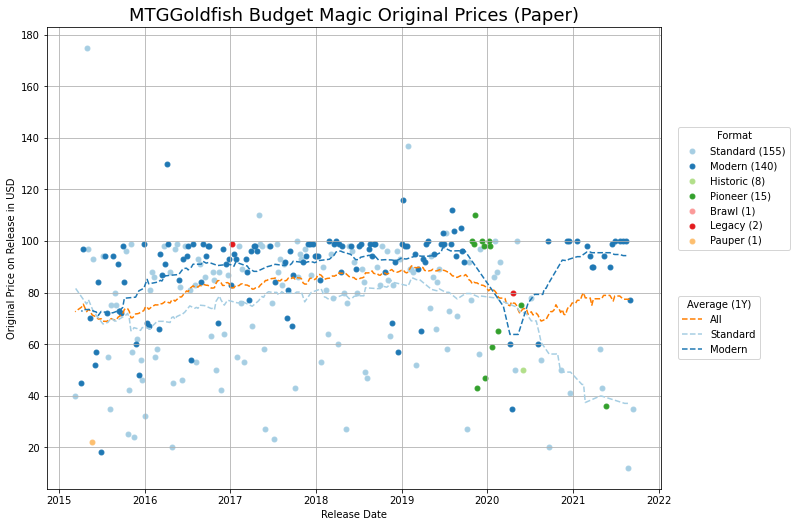

In [ ]:
scatter_plot_by_format('og_paper_price', 'MTGGoldfish Budget Magic Original Prices (Paper)', 'Original Price on Release in USD')

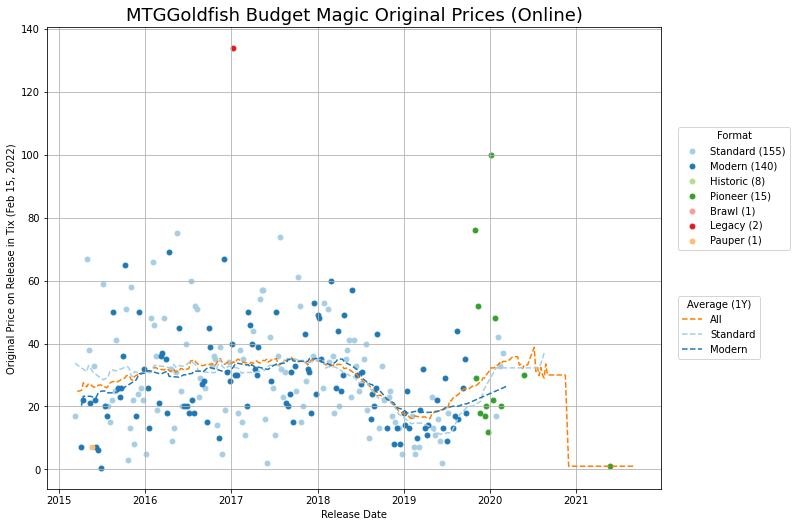

In [ ]:
# Lots of lost data for recent lists because of MTG Arena budget decks not having original Tix prices displayed
scatter_plot_by_format('og_online_price', 'MTGGoldfish Budget Magic Original Prices (Online)', 'Original Price on Release in Tix')

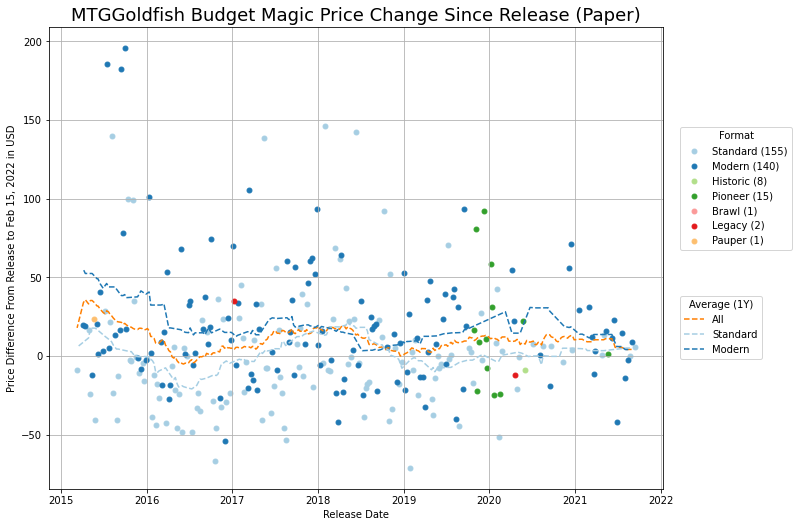

In [ ]:
scatter_plot_by_format('paper_delta', 'MTGGoldfish Budget Magic Price Change Since Release (Paper)', 'Price Difference From Release to Feb 15, 2022 in USD')

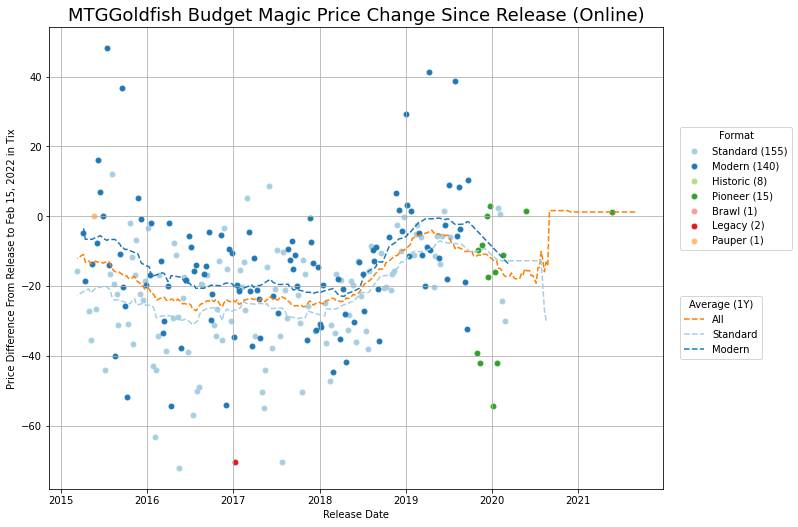

In [ ]:
scatter_plot_by_format('online_delta', 'MTGGoldfish Budget Magic Price Change Since Release (Online)', 'Price Difference From Release to Feb 15, 2022 in Tix')

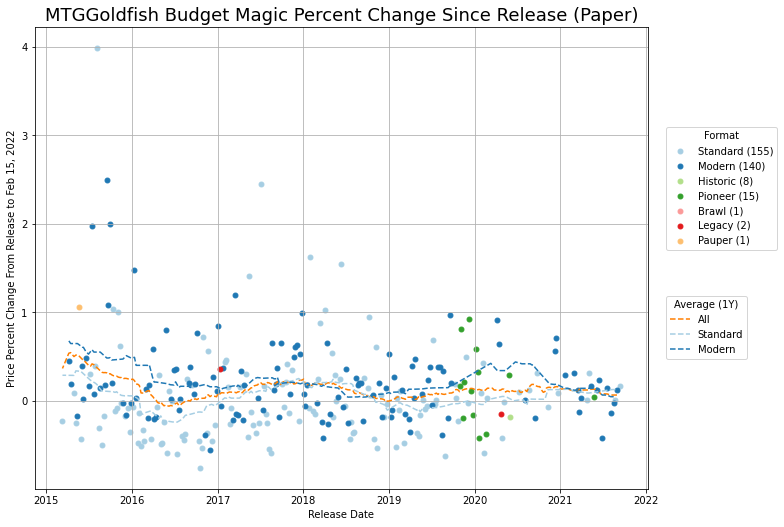

In [ ]:
scatter_plot_by_format('paper_percent_change', 'MTGGoldfish Budget Magic Percent Change Since Release (Paper)', 'Price Percent Change From Release to Feb 15, 2022')

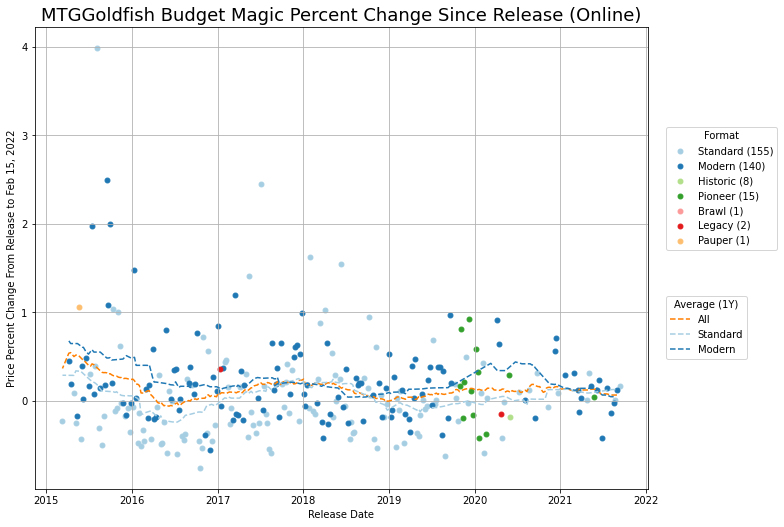

In [ ]:
scatter_plot_by_format('paper_percent_change', 'MTGGoldfish Budget Magic Percent Change Since Release (Online)', 'Price Percent Change From Release to Feb 15, 2022')

In [ ]:
def get_top_stats(df, column):
  largest = df.nlargest(5, column)[['formatted_name', column, 'url', 'date', 'format']]
  smallest = df.nsmallest(5, column)[['formatted_name', column, 'url', 'date', 'format']]

  stats = largest.append(smallest).sort_values(column, ascending=False)

  stats['formatted_name'] = stats['format'] + ' ' + stats['formatted_name'] + ' (' + stats['date'].dt.strftime('%b %Y') + ')'

  return stats[['formatted_name', column, 'url']]

In [ ]:
get_top_stats(df, 'current_paper')

,formatted_name,current_paper,url
297,Modern Ironworks Combo (Sep 2015),293.92,https://www.mtggoldfish.com/articles/budget-ma...
308,Modern UB Mill (Jul 2015),279.85,https://www.mtggoldfish.com/articles/budget-ma...
299,Modern Heartless Summoning (Sep 2015),255.34,https://www.mtggoldfish.com/articles/budget-ma...
212,Standard WB Aristocats (May 2017),236.36,https://www.mtggoldfish.com/articles/budget-ma...
175,Standard WB Aristocrats (Jan 2018),236.02,https://www.mtggoldfish.com/articles/budget-ma...
161,Standard Flaming Wizard Burn (May 2018),22.17,https://www.mtggoldfish.com/articles/budget-ma...
242,Standard Poisonless Infect (Oct 2016),21.34,https://www.mtggoldfish.com/articles/budget-ma...
310,Modern Zombie Hunt (Jun 2015),21.00,https://www.mtggoldfish.com/articles/budget-ma...
210,Standard Two-Tix Red (May 2017),19.70,https://www.mtggoldfish.com/articles/budget-ma...
2,Standard Simic Kicker 2022 (Aug 2021),12.11,https://www.mtggoldfish.com/articles/budget-ma...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
get_top_stats(df, 'current_online')

,formatted_name,current_online,url
24,"Modern ""Manaless"" Affinity (Feb 2021)",231.59,https://www.mtggoldfish.com/articles/budget-ma...
9,Modern Real Affinity (Jun 2021),202.95,https://www.mtggoldfish.com/articles/budget-ma...
45,Modern 16 Rack (Aug 2020),98.67,https://www.mtggoldfish.com/articles/budget-ma...
49,Standard Mono-Black No Cat Archfiend Sac (Jul ...,79.76,https://www.mtggoldfish.com/articles/budget-ma...
4,Standard Hideous Copy Mill 2022 (Aug 2021),77.92,https://www.mtggoldfish.com/articles/budget-ma...
176,Standard RB Pirates (Jan 2018),1.16,https://www.mtggoldfish.com/articles/budget-ma...
118,Standard Goblin Calamity (Mar 2019),1.03,https://www.mtggoldfish.com/articles/budget-ma...
41,Standard UG Kicker (Sep 2020),0.98,https://www.mtggoldfish.com/articles/budget-ma...
2,Standard Simic Kicker 2022 (Aug 2021),0.53,https://www.mtggoldfish.com/articles/budget-ma...
310,Modern Zombie Hunt (Jun 2015),0.47,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'paper_delta')

,formatted_name,paper_delta,url
297,Modern Ironworks Combo (Sep 2015),195.92,https://www.mtggoldfish.com/articles/budget-ma...
308,Modern UB Mill (Jul 2015),185.85,https://www.mtggoldfish.com/articles/budget-ma...
299,Modern Heartless Summoning (Sep 2015),182.34,https://www.mtggoldfish.com/articles/budget-ma...
175,Standard WB Aristocrats (Jan 2018),146.02,https://www.mtggoldfish.com/articles/budget-ma...
156,Standard Mono-Blue Storm (Jun 2018),142.22,https://www.mtggoldfish.com/articles/budget-ma...
71,Standard AnaxCleave Red (Feb 2020),-51.45,https://www.mtggoldfish.com/articles/budget-ma...
199,Standard Demon Fling Jund (Aug 2017),-53.56,https://www.mtggoldfish.com/articles/budget-ma...
236,Modern Mono-White Blink (Nov 2016),-53.71,https://www.mtggoldfish.com/articles/budget-ma...
242,Standard Poisonless Infect (Oct 2016),-66.66,https://www.mtggoldfish.com/articles/budget-ma...
123,Standard Four-Color Gates (Jan 2019),-71.04,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'online_delta')

,formatted_name,online_delta,url
308,Modern UB Mill (Jul 2015),48.27,https://www.mtggoldfish.com/articles/budget-ma...
113,Modern Mardu Aristocrats (Apr 2019),41.24,https://www.mtggoldfish.com/articles/budget-ma...
97,Modern Hammer Time (Jul 2019),38.60,https://www.mtggoldfish.com/articles/budget-ma...
299,Modern Heartless Summoning (Sep 2015),36.82,https://www.mtggoldfish.com/articles/budget-ma...
127,Modern RB Reanimator (Jan 2019),29.28,https://www.mtggoldfish.com/articles/budget-ma...
256,Standard UR Dragons (Jul 2016),-57.03,https://www.mtggoldfish.com/articles/budget-ma...
279,Standard Displacer Combo (Feb 2016),-63.27,https://www.mtggoldfish.com/articles/budget-ma...
230,Legacy Burn (Jan 2017),-70.30,https://www.mtggoldfish.com/articles/budget-ma...
202,Standard GG Panharmonicon (Jul 2017),-70.31,https://www.mtggoldfish.com/articles/budget-ma...
264,Standard Ever After Reanimator (May 2016),-72.08,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'paper_percent_change')

,formatted_name,paper_percent_change,url
305,Standard UR Tutelage Mill (Aug 2015),3.988857,https://www.mtggoldfish.com/articles/budget-ma...
299,Modern Heartless Summoning (Sep 2015),2.497808,https://www.mtggoldfish.com/articles/budget-ma...
205,Standard Mono-Blue Reservoir (Jul 2017),2.444348,https://www.mtggoldfish.com/articles/budget-ma...
297,Modern Ironworks Combo (Sep 2015),1.999184,https://www.mtggoldfish.com/articles/budget-ma...
308,Modern UB Mill (Jul 2015),1.977128,https://www.mtggoldfish.com/articles/budget-ma...
262,Standard UW Clue Flash (May 2016),-0.586341,https://www.mtggoldfish.com/articles/budget-ma...
199,Standard Demon Fling Jund (Aug 2017),-0.588571,https://www.mtggoldfish.com/articles/budget-ma...
256,Standard UR Dragons (Jul 2016),-0.597037,https://www.mtggoldfish.com/articles/budget-ma...
93,Standard Rotation-Proof Mono-Red Cavalcade (Au...,-0.629718,https://www.mtggoldfish.com/articles/budget-ma...
242,Standard Poisonless Infect (Oct 2016),-0.757500,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'online_percent_change')

,formatted_name,online_percent_change,url
210,Standard Two-Tix Red (May 2017),4.375000,https://www.mtggoldfish.com/articles/budget-ma...
113,Modern Mardu Aristocrats (Apr 2019),3.749091,https://www.mtggoldfish.com/articles/budget-ma...
97,Modern Hammer Time (Jul 2019),2.969231,https://www.mtggoldfish.com/articles/budget-ma...
308,Modern UB Mill (Jul 2015),2.413500,https://www.mtggoldfish.com/articles/budget-ma...
312,Modern Blistering Rage (Jun 2015),2.315714,https://www.mtggoldfish.com/articles/budget-ma...
252,Standard Alchemist Burn (Aug 2016),-0.962157,https://www.mtggoldfish.com/articles/budget-ma...
213,Standard Esper Haven (May 2017),-0.963684,https://www.mtggoldfish.com/articles/budget-ma...
253,Standard UG Emerge (Aug 2016),-0.963846,https://www.mtggoldfish.com/articles/budget-ma...
190,Standard Revolt Treasure Ramp (Oct 2017),-0.968269,https://www.mtggoldfish.com/articles/budget-ma...
259,Standard Mono-White Angels (Jun 2016),-0.969000,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'og_paper_price')

,formatted_name,og_paper_price,url
318,Standard Wg Prowess (Apr 2015),175.0,https://www.mtggoldfish.com/articles/budget-ma...
123,Standard Four-Color Gates (Jan 2019),137.0,https://www.mtggoldfish.com/articles/budget-ma...
270,Modern Red-White Allies (Apr 2016),130.0,https://www.mtggoldfish.com/articles/budget-ma...
126,Modern Restore Balance 2019 (Jan 2019),116.0,https://www.mtggoldfish.com/articles/budget-ma...
96,Modern Leyline of Abundance Combo (Aug 2019),112.0,https://www.mtggoldfish.com/articles/budget-ma...
315,Pauper UB Teachings Control (May 2015),22.0,https://www.mtggoldfish.com/articles/budget-ma...
41,Standard UG Kicker (Sep 2020),20.0,https://www.mtggoldfish.com/articles/budget-ma...
267,Standard Mono-Blue Brains (Apr 2016),20.0,https://www.mtggoldfish.com/articles/budget-ma...
310,Modern Zombie Hunt (Jun 2015),18.0,https://www.mtggoldfish.com/articles/budget-ma...
2,Standard Simic Kicker 2022 (Aug 2021),12.0,https://www.mtggoldfish.com/articles/budget-ma...


In [ ]:
get_top_stats(df, 'og_online_price')

,formatted_name,og_online_price,url
230,Legacy Burn (Jan 2017),134.0,https://www.mtggoldfish.com/articles/budget-ma...
76,Pioneer Rakdos Madness Vampires (Jan 2020),100.0,https://www.mtggoldfish.com/articles/budget-ma...
85,Pioneer UR Prowess (Oct 2019),76.0,https://www.mtggoldfish.com/articles/budget-ma...
264,Standard Ever After Reanimator (May 2016),75.0,https://www.mtggoldfish.com/articles/budget-ma...
202,Standard GG Panharmonicon (Jul 2017),74.0,https://www.mtggoldfish.com/articles/budget-ma...
294,Standard Eldrazi Aggro (Oct 2015),3.0,https://www.mtggoldfish.com/articles/budget-ma...
104,Standard Creeping Zombies (Jun 2019),2.0,https://www.mtggoldfish.com/articles/budget-ma...
210,Standard Two-Tix Red (May 2017),2.0,https://www.mtggoldfish.com/articles/budget-ma...
11,Pioneer Mono-Black Devotion (May 2021),1.0,https://www.mtggoldfish.com/articles/budget-ma...
310,Modern Zombie Hunt (Jun 2015),0.5,https://www.mtggoldfish.com/articles/budget-ma...


['title', 'url', 'date', 'current_paper', 'current_online',
       'og_paper_price', 'og_online_price', 'format', 'formatted_name',
       'paper_delta', 'online_delta', 'paper_percent_change',
       'online_percent_change']

In [ ]:
def stacked_histogram_by_format(column, title, xlabel, ylabel, bins):

  colors = list(df['format'].unique()) # colors is formats

  sum_histogram = None
  for i in range(0 , len(colors)):
      data = df.dropna(subset=[column]).loc[df['format'] == colors[i]]

      data['bin'] = pd.cut(data[column], bins, right=False)

      data_binned = data.groupby(data['bin'])['bin'].count()

      plt.bar(range(len(data_binned)), data_binned.values, color=categorical_colormap(i), label=colors[i], bottom=sum_histogram)

      inf = '∞'
      bin_labels = bins[:]
      bin_labels[-1] = inf
      tick_pos = np.array(range(len(data_binned) + 1)) - 0.5
      plt.xticks(tick_pos, bin_labels)


      sum_histogram = data_binned.values if sum_histogram is None else data_binned.values + sum_histogram

  plt.legend(labels=[f"{label} ({format_counts[label]})" for label in list(df['format'].unique())],
                              bbox_to_anchor=(1.02,0.65), loc="center left", title="Format")
  
  ymin, ymax = plt.ylim()

  plt.ylim(ymin * 1.05, ymax * 1.05)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.title(title, fontsize=18)

  plt.show()

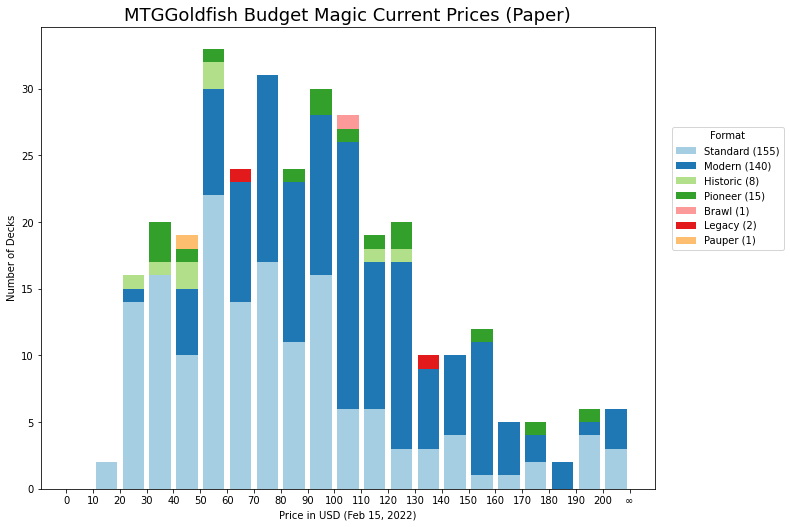

In [ ]:
stacked_histogram_by_format('current_paper', 'MTGGoldfish Budget Magic Current Prices (Paper)', 'Price in USD (Feb 15, 2022)', 'Number of Decks', bins=list(range(0,210,10)) + [float("inf")])